# Binær klassifisering ved hjelp av et nevralt nettverk

## Introduksjon

I denne oppgaven skal det utføres en binær klassifisering av ulike typer bilder. Modellen som skal brukes er et nevralt nettverk med en forholdsvis beskjeden dybde. 
$\color{red}{Mer \, spesifikt \, om \, hvordan \, modellen \, er \, bygget \, opp?}$

Tilnærmingen til problemet er todelt: 
* En treningsfase der parametrene assosiert med hver transformasjon som gir lavest mulig avvik finnes. Avviket beregnes ved hjelp av en kostfunksjon,som benytter seg av et sett med labels. Dette er essensielt en liste over de ulike punktenes reelle binære klassifisering, slik at modellen sin klassifisering kan sammenlignes med denne. 
* En valideringsfase der bilder som ikke ble brukt i treningsfasen transformeres med parameterne som ble funnet. Herfra kan man trekke en konklusjon om modellen klassifiserer bildene på en god måte eller ikke. 

I testproblem 1 skal punkter i planet klassifiseres. Det skal skilles mellom to typer punkter. Her er de valgt til å være henholdsvis røde og blå. "Bildet" i dette problemet er et punkt, kun beskrevet av to koordinater $(x,y)$. Modellen skal dermed trenes til å avgjøre om et vilkårlig punkt er rødt eller blått.

I testproblem 2 skal siffer fra MNIST klassifiseres. Her er det snakk om virkelige bilder med lav oppløsning. Størrelsen på bildene er 28 x 28 piksler. Bildene i settene fra MNIST består av siffer fra 0-9, dvs 10 ulike klasser av bilder. For at dette skal passe inn i vår binære klassifiseringsmodell holder vi oss til kun to forskjellige siffer, som for eksempel 4 og 9. 


## Testproblem 1 - punkter i planet


143.07956017161044 35.59915588679443


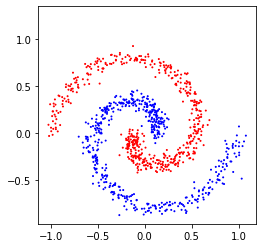

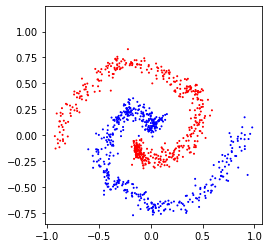

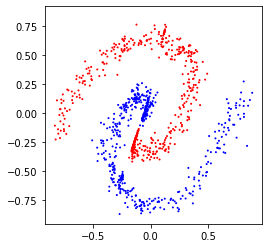

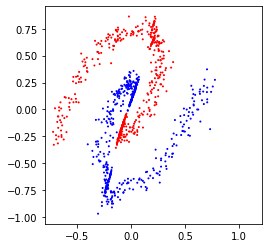

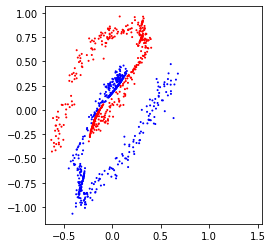

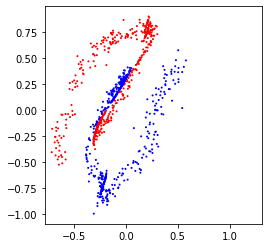

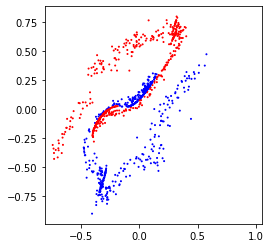

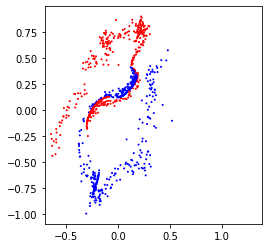

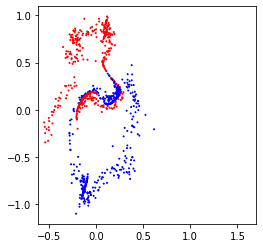

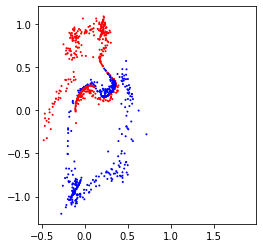

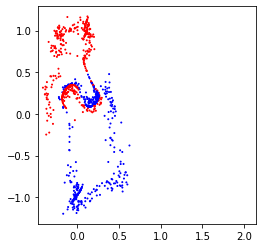

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import math #IMPORTERTE MATH FORDI JEG FIKK EN FEILKODE OM AT DEN IKKE FINNES!

I = 1000  #antall bilder, kan økes til 1000 punkter/bilder
d = 2   #x- og y-koordinat
K = 10  #antall transformajsoner, kan økes til 15-20
h = 0.1 #skrittlengde
iterations = 1000  #kan økes til 40 000

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    return np.cosh(x)**(-2)

def eta(x):
    return 0.5*(1+np.tanh(x/2))

def eta_der(x):
    return np.e**(x)*(np.e**(x)+1)**(-2)

def make_spiral(m, phi, n_turns):
    '''Makes points on a spiral
    
    This is a utility function for get_data_spiral_2d'''
    r = np.linspace(0.1, 1.0, m)
    a = np.linspace(0.1, 2.0 * np.pi * n_turns, m)
    xs = r * np.cos(a + phi)
    ys = r * np.sin(a + phi)
    return np.stack([xs, ys])

def get_data_spiral_2d(n_samples=I): #Stod n_samples=200
    '''Create "observations" for training.
    
    Creates n_samples dots on two intertwined spirals.
    The dots are classified based on which spiral they belong to and
    then fuzzed by perturbing the coordinates and permuting the ordering.'''
    m1 = math.ceil(n_samples / 2)
    m2 = n_samples - m1
    
    n_turns = 1.0
    
    phi1 = np.pi
    d1 = make_spiral(m1, phi1, n_turns)

    
    phi2 = (phi1 + np.pi) % (2.0 * np.pi)
    d2 = make_spiral(m2, phi2, n_turns)
    
    features = np.hstack((d1, d2))
    labels = np.ones((n_samples,1), dtype='bool_')
    labels[m1:] = False
    
    features = features + .05 * np.random.randn(*features.shape)
    
    indexes = np.random.permutation(n_samples)
    features = features[:, indexes]
    labels = labels[indexes]

    return features, labels

def adam_method(x, x_der, m_jn, v_jn):
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def plain_vanilla(x,x_der):
    tau = 0.05
    x -= tau*x_der
    return x
    
def train(Y_0, c, d, I):
    #Forberedelser:
    c = c[:,0]  #for å få en Ix1 vektor 
    Y_Kk = np.zeros((K+1,d,I))  #Med K transformasjoner får vi K+1 Y_k'er
    Y_Kk[0,:,:] = Y_0
    b_k_dim = np.zeros((K,d,I))

    #Til Adam-metoden:
    #Bedre å plassere disse inne i funksjonen til Adam-metoden?
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])

    #Til Plain vanilla:
    tau = 0.05

    #Parameters that change for each while loop
    W_k = np.random.randn(K,d,d)
    b_k = np.random.randn(K,d,1)  
    omega = np.random.randn(d)  
    my = np.random.rand() 

    j = 1   #Må starte på 1
    J = np.zeros(iterations)

    while j <= iterations:
        #KODEN BØR GJØRES MER MODULÆR, MEN DET KAN ORDNES SEINERE
        #MANGLER OGSÅ DE GREIENE OM Å LAGRE I MINNET VEL? MED MINDRE JEG HAR MISFORSTÅTT HVA HAN MENER MED DET
        for i in range(K): 

            b_k_dim[i,:,:] = b_k[i,:,:]   #Lager I kolonner med b_k[i,:,:] for å kunne plusse sammen med en dxI matrise
            #ER LINJEN OVER NØDVENDIG? SKJØNNER IKKE HELT HVORFOR DET ER EN B_K_DIM I TILLEGG TIL B_K?
            #KUNNE MAN IKKE BARE PLUUSET PÅ B_K I LINJEN YNDER, I STEDET FOR Å BRUKE B_K_DIM?
            Y_Kk[i+1,:,:] = Y_Kk[i,:,:] + h*sigma(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])  #plusser b_k med alle kolonnene i Y_Kk

        YT_k = np.transpose(Y_Kk[-1,:,:]) #Enklere notasjon
        vec_I = np.ones(I) #ER DENNE NØDVENDIG? FUNGERER DET IKKE Å BARE ADDERE MY? (SOM F.EKS I P_K) VIRKER SOM AT DET SKAL FUNGERE!
        Z = eta(YT_k @ omega + my*vec_I)  #Z er en Ix1 vektor
        J[j-1] = 0.5*np.linalg.norm(Z-c)**2 #J blir en array med iterations antall verdier

        P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my*vec_I)) #Blir en dxI matrise
        #HVORFOR ER DET BRUKT OUTER OVER? SKJØNNER IKKE HELT DET?
        J_der_my = eta_der(YT_k @ omega + my*vec_I) @ (Z-c)    #Blir en skalar  
        J_der_omega = Y_Kk[-1,:,:] @ ((Z-c) * eta_der(YT_k @ omega + my*vec_I)) #Blir en dx1 vektor

        P_Kk = np.zeros((K,d,I)) #K matriser, skal ikke ha med P_0
        P_Kk[-1,:,:] = P_k      #Legger P_k bakerst i P_Kk
        for i in range(K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
            P_Kk[i-1,:,:] = P_Kk[i,:,:] + h*np.transpose(W_k[i-1,:,:]) @ (sigma_der(W_k[i-1,:,:] @ Y_Kk[i-1,:,:] +b_k_dim[i-1,:,:]) * P_Kk[i,:,:])

        J_der_W = np.zeros((K,d,d))
        J_der_b = np.zeros((K,d,1))
        vec_I = np.ones((I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
        #P_Kk går fra P_1(=indeks 0) til P_K(=indeks K-1)
        for i in range(K):
            val = P_Kk[i,:,:] * sigma_der(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])
            #BLIR DET RETT INDEX PÅ P_KK I VAL? SKULLE DET IKKE VÆRT I+1? ELLER ER P_KK EN MATRISE SOM REPRESENTERER P_K+1 I HEFTET? 
            J_der_W[i,:,:] = h*(val @ np.transpose(Y_Kk[i,:,:]))
            J_der_b[i,:,:] = h*(val @ vec_I)

        #Adam-metoden, oppdaterer alle verdIer.
        v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
        m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
        my, m_j[0],v_j[0] = adam_method(my,J_der_my,m_j[0],v_j[0])
        omega, m_j[1],v_j[1] = adam_method(omega,J_der_omega,m_j[1],v_j[1]) 
        b_k, m_j[2],v_j[2] = adam_method(b_k,J_der_b,m_j[2],v_j[2])
        W_k, m_j[3],v_j[3] = adam_method(W_k,J_der_W,m_j[3],v_j[3]) 
        #DISSE TO METODENE GIR SAMME?
        #Plain vanilla
        #my = plain_vanilla(my,J_der_my)
        #omega = plain_vanilla(omega, J_der_omega)
        #b_k = plain_vanilla(b_k,J_der_b)
        #W_k = plain_vanilla(W_k, J_der_W)
        j+= 1
        
    return J, Y_Kk, c

Y_0, c = get_data_spiral_2d()  
J, Y_Kk, c = train(Y_0, c, d, I)
print(J[0],J[-1])  #god overenstemmelse
plot_progression(Y_Kk, c) 

In [ ]:
'''
This module contains three functions that can plot some aspects of the simple 2d-points-in-a-spiral problem.
The functions can be used as is, without looking into their inner workings.
You can also use them as inspiration for other ways of visualizing what your neural net does.
'''
import numpy as np
import matplotlib.pyplot as plt
###Visuals:

def forward_function(grid): #Denne må nesten transformere gridet slik som Y0, slik at vi kan se hvilke punkter av gridet som hører til hvilken arm? Ellernoe lignende? Se docstring til plot_model!
    ''' A function that takes one argument, an S-by-2 matrix of S datapoints, and
    returns a vector of S classification values.'''
    #YT_k = np.transpose(Y_Kk[-1,:,:]) #Enklere notasjon
    #vec_I = np.ones(I) #ER DENNE NØDVENDIG? FUNGERER DET IKKE Å BARE ADDERE MY? (SOM F.EKS I P_K) VIRKER SOM AT DET SKAL FUNGERE!
    #Z = eta(np.transpose(Y0) @ omega + my)  #Z er en Ix1 vektor
    Z, c = get_data_spiral_2d() #Dette blir naturligvis ikke riktig, men noe må gjøres med den første!
    return Z 
                                        

#LAST FUNCTION SKAL VISST BARE TRANSFORMERE PUNKTENE! BURDE FUNGERT PÅ, MEN USIKKER PÅ OM Z UNDER ER RETT
def last_function(grid): #Siste Y
    ''' A function that takes one argument, and S-by-2 matrix of S intermediate states in
    the network, and returns a vector of S classification values.
    It should multiply by w, add μ and evaluate 𝜂. '''
    #YT_k = np.transpose(Y_Kk[-1,:,:]) #Enklere notasjon
    vec_I = np.ones(I) #ER DENNE NØDVENDIG? FUNGERER DET IKKE Å BARE ADDERE MY? (SOM F.EKS I P_K) VIRKER SOM AT DET SKAL FUNGERE!
    Z = eta(np.transpose(grid) @ omega + my)  #Gridet måtte transponeres først! (se formel). Nå fikk vi ut noe litt mer fornuftig :)
    return Z
    
def plot_progression(Y, C):
    '''
    This function should make K+1 plots showing how, as the network progresses through its layers,
    the datapoints are drawn apart in such a way that they can be separated by a straight line.
    
    Y: A K+1-by-I-by-2 matrix of the values for each data point in the training set in each layer.
    C: An I-by-1 matrix of the labels corresponding to the datra points in Y.
    '''
    for k in range(Y.shape[0]):
        show_dots(Y[k,:,:],C.flatten())
        plt.show()


def plot_model(forward_function, Ys, C, n):
    '''
    Make a map that shows what part of the 2d plane is classified as belonging to which spiral arm.
    Also plot the training data in Ys, C.
    
    forward_function: A function that takes one argument, an S-by-2 matrix of S datapoints, and
        returns a vector of S classification values.
        
        Hint: This function will use the weights you have found, so you might want it to be a method on a
        class called something like Network or Model.
    Ys: An I-by-2 matrix. Corresponding to Y[0,:,:]
    C: An I-by-1 matrix of the labels corresponding to the datra points in Ys.
    n: Number of test-points in each direction. This controls the resolution of the plot.
    '''
    grid, coordinates = get_discretization(Ys, n)

    Z = forward_function(grid) #Jeg tenker at forward_function skal utføre den første transformasjonen på gridet!
    l = np.linspace(0,1,8)
    l = np.array([shading(x) for x in l])

    plot_contours(*coordinates, Z, l, Ys, C.flatten())


def plot_separation(last_function, Ys, C, n):
    '''
    Show how the training data is represented in the last layer. Also maps the rest of the possible points in the plane.
    
    last_function: A function that takes one argument, and S-by-2 matrix of S intermediate states in
        the network, and retruns a vector of S classification values.
        It should multiply by w, add μ and evaluate 𝜂.
        
        Hint: This function will use the weights you have found, so you might want it to be a method on a
        class called something like Network or Model.
    Ys:An I-by-2 matrix. Corresponding to Y[-1,:,:].
    C: An I-by-1 matrix of the labels corresponding to the datra points in Ys.
    n: Number of test-points in each direction. This controls the resolution of the plot.
    '''
    grid, coordinates = get_discretization(Ys, n)

    Z = last_function(grid) #transformerer grid-punktene!

    l = np.linspace(0,1,500)

    plot_contours(*coordinates, Z, l, Ys, C.flatten())



######## Internals
def show_dots(positions, labels):
    '''Visualize the output of get_data_spiral_2d'''
    plt.scatter(x=positions[0,:], y=positions[1,:], s=1, c=labels, cmap='bwr')
    plt.axis([-1.2, 1.2, -1.2, 1.2])
    plt.axis('square')


def plot_contours(box, xcoordinates, ycoordinates, Z, l, Ys, C1):
    n = xcoordinates.size
    plt.contourf(xcoordinates, ycoordinates, Z.reshape((n,n)), cmap='seismic', levels=l)
    plt.contour(xcoordinates, ycoordinates, Z.reshape((n,n)), levels=1, colors='k')
    plt.scatter(x=Ys[0,:], y=Ys[1,:], s=1, c=C1, cmap='bwr')
    plt.axis(box)
    plt.axis('equal')
    plt.show()


def get_discretization(Ys, n):
    xmin, xmax, ymin, ymax = get_box(Ys)
    xcoordinates = np.linspace(xmin, xmax, n)
    ycoordinates = np.linspace(ymin, ymax, n)
    grid = get_grid(xcoordinates, ycoordinates)
    coordinates = ([xmin, xmax, ymin, ymax], xcoordinates, ycoordinates)
    return grid, coordinates


def get_box(Ys):
    xmin = min(Ys[0,:])
    xmax = max(Ys[0,:])
    xdelta = xmax-xmin
    xmin -= 0.2*xdelta
    xmax += 0.2*xdelta
    ymin = min(Ys[1,:])
    ymax = max(Ys[1,:])
    ydelta = ymax-ymin
    ymin -= 0.2*ydelta
    ymax += 0.2*ydelta
    return xmin, xmax, ymin, ymax

    
def get_grid(xcoordinates, ycoordinates):
    xv, yv = np.meshgrid(xcoordinates, ycoordinates)
    xs = xv.reshape(-1)
    ys= yv.reshape(-1)
    grid = np.stack([xs,ys])
    return grid


def shading(x):
    return shading1(shading2(x))


def shading1(x):
    if x == 0.0:
        return 0.0
    return 0.5 * np.tanh(np.tan(x * np.pi + np.pi / 2.0)) + 0.5


def shading2(x):
    if x < 0.5:
        return 0.5 - np.sqrt(0.25 - x**2)
    else:
        return 0.5 + np.sqrt(0.25 -(x-1.0)**2)

#plot_model(forward_function,Y_Kk[-1,:,:],c,1000) #forward_function fungerer ikke som den skal! 
#Jeg skjønner ikke helt hva som er hensikten med plot_model, hva skal den plotte?
plot_separation(last_function,Y_Kk[-1,:,:],c,1000) #Denne gir et fint plot derimot

#Nå skjer det fryktelig rare ting her!!
#Etter at jeg lagde en funksjon ut av det. 
#Koden må forbedre før den kan brukes!
#dritt

## Testproblem 2 - håndskrevne siffer

In [ ]:
#Kopierer inn koden fra loader.py

import os
import struct
from array import array as pyarray
import numpy as np


def get_dataset(dataset="training", digit1=2, digit2=7, path="."):
    images, labels = load_mnist(dataset=dataset, path=path)
    images = np.reshape(images, newshape=(images.shape[0],-1), order='C') # Create (60 000 x whatever) 2D-matrix.
    labels = np.array(labels)

    label_indexes = (labels == digit1) | (labels == digit2)
    labels = labels[label_indexes]
    images = images[label_indexes]
    return images.T, (labels == digit1).reshape((-1,1))


### Internals:


def load_mnist(dataset="training", digits=np.arange(10), path="."):
    fname_img, fname_lbl = get_file_names(dataset, path)
    lbl = read_labels(fname_lbl)
    img, size, rows, cols = read_images(fname_img)

    images = np.array(img, order='C', dtype=np.uint8)
    images = images.reshape(size, rows, cols)
    labels = np.zeros((size, 1), dtype=np.int8)
    for i in range(size):
        labels[i] = lbl[i]
    labels2 = [label[0] for label in labels]
    return images, labels2


def get_file_names(dataset, path):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")
    return fname_img, fname_lbl


def read_labels(fname_lbl):
    with open(fname_lbl, 'rb') as flbl:
        _, size = struct.unpack(">II", flbl.read(8))
        lbl = pyarray("b", flbl.read())
    return lbl


def read_images(fname_img):
    with open(fname_img, 'rb') as fimg:
        _, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = pyarray("B", fimg.read())
    return img, size, rows, cols

Y_0, c = get_dataset() #gets data for training
J, Y_Kk, c = train(Y_0, c, 784, 12223)
#print(J[0],J[-1])  #god overenstemmelse
#plot_progression(Y_Kk, c) 

#DETTE ER BARE TULL MED DENKODEN SOM ER NÅ!!!